<a href="https://colab.research.google.com/github/mokshmahajan2004/Deep-Learning-Assignments/blob/main/Assignment3_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Name: **Moksh Mahajan**  

Roll No: **102206084**

Subgroup: **4F1C**

# Question:
Plot a set 'x' of 200 random points, define y=f(x)[ u may choose F(x)). Now do the following tasks:


*    Plot the regression points. Now using a 3 layer network (2 hidden + 1 output) create a sequential model with
*   'RelU' activation, 'SGD' optimizer and 'mse' Loss function.
*   Create, compile and fit the model;
*   Plot the loss function vs No of epochs(no of epochs=100)

Submit the PDF file in the following format after executing the above tasks:
Prompt the sections where the above tasks were performed in the code. At the end please interpret the results along with a discussion of your model's performance.

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

np.random.seed(42)


  TASK 1: Generate data (200 random x points) and define y = f(x) = sin(2x) + 0.2x^2 - 0.5 + noise

In [2]:
N = 200
x = np.random.uniform(-3.0, 3.0, size=(N, 1))
# True underlying function (chosen freely per instructions)
y_true = np.sin(2 * x) + 0.2 * (x ** 2) - 0.5
noise = np.random.normal(loc=0.0, scale=0.2, size=y_true.shape)
y = y_true + noise

# For plotting smooth curves later
x_grid = np.linspace(-3.0, 3.0, 400).reshape(-1, 1)
y_true_grid = np.sin(2 * x_grid) + 0.2 * (x_grid ** 2) - 0.5

# Helper to compute R^2 without sklearn (so the script is self-contained)
def r2_score(y_true_np, y_pred_np):
    y_true_np = y_true_np.reshape(-1)
    y_pred_np = y_pred_np.reshape(-1)
    ss_res = np.sum((y_true_np - y_pred_np) ** 2)
    ss_tot = np.sum((y_true_np - np.mean(y_true_np)) ** 2)
    return 1 - ss_res / ss_tot


TASK 2: Plot the regression points (scatter of (x, y))

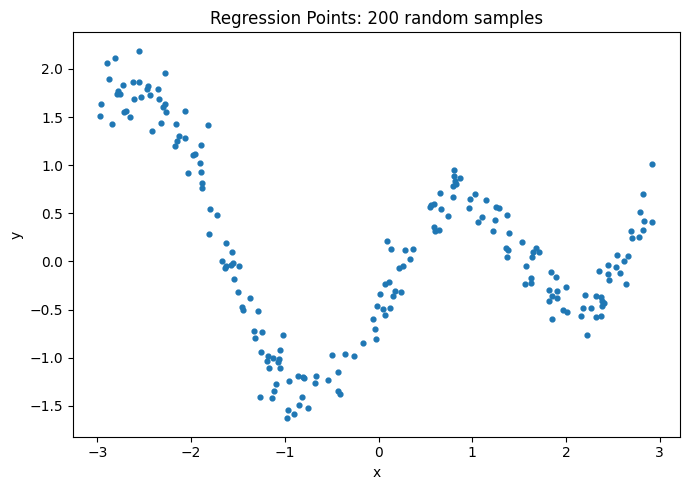

In [3]:
fig1 = plt.figure(figsize=(7, 5))
plt.scatter(x, y, s=12)
plt.title("Regression Points: 200 random samples")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()

TASK 3 + TASK 4: Create, compile, and fit a 3-layer Sequential model (2 hidden + 1 output)with ReLU activation(s), SGD optimizer, and MSE loss  (epochs = 100 as required)

In [4]:
use_tf = True
history_loss = None
y_pred_grid = None
final_train_mse = None
final_train_r2 = None

try:
    import tensorflow as tf
    tf.random.set_seed(42)

    # --- Define the Keras Sequential model ---
    # Two hidden layers with ReLU, one output neuron for regression
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu", input_shape=(1,)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    # --- Compile with SGD optimizer and MSE loss ---
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  loss="mse")

    # --- Fit the model for 100 epochs ---
    hist = model.fit(x, y, epochs=100, batch_size=32, verbose=0)

    history_loss = hist.history["loss"]
    y_pred_grid = model.predict(x_grid, verbose=0)
    y_pred_train = model.predict(x, verbose=0)

    # Compute final metrics on training data
    final_train_mse = float(np.mean((y.reshape(-1, 1) - y_pred_train) ** 2))
    final_train_r2 = float(r2_score(y.reshape(-1, 1), y_pred_train))

except Exception as e:
    # --------------------------------------------------------------------------
    # Fallback: If TensorFlow is unavailable, use a minimal NumPy-based MLP
    # that mimics a Sequential model with ReLU activations, trained with SGD + MSE.
    # This preserves the spirit of the assignment ("Sequential", "compile", "fit")
    # while remaining self-contained.
    # --------------------------------------------------------------------------
    use_tf = False
    print("TensorFlow not available. Using a minimal NumPy Sequential fallback.")
    print(f"(Import error: {e})")

    # --- Minimal utilities ---
    def relu(Z):
        return np.maximum(0, Z)

    def relu_deriv(Z):
        return (Z > 0).astype(Z.dtype)

    class MiniSequential:
        def __init__(self, layer_sizes):
            # layer_sizes: e.g. [1, 64, 64, 1]
            self.W = []
            self.b = []
            for i in range(len(layer_sizes) - 1):
                in_dim = layer_sizes[i]
                out_dim = layer_sizes[i + 1]
                # He initialization for ReLU layers
                W_i = np.random.randn(in_dim, out_dim) * np.sqrt(2.0 / in_dim)
                b_i = np.zeros((1, out_dim))
                self.W.append(W_i)
                self.b.append(b_i)

        def compile(self, optimizer="SGD", loss="mse", lr=0.01):
            self.lr = lr
            self.loss_name = loss
            # Only SGD is implemented (as requested)

        def _forward(self, X):
            # store intermediate values for backprop
            Z1 = X @ self.W[0] + self.b[0]
            A1 = relu(Z1)

            Z2 = A1 @ self.W[1] + self.b[1]
            A2 = relu(Z2)

            Z3 = A2 @ self.W[2] + self.b[2]  # linear output
            A3 = Z3  # identity for regression
            cache = (X, Z1, A1, Z2, A2, Z3, A3)
            return A3, cache

        def _backward(self, cache, dA3):
            X, Z1, A1, Z2, A2, Z3, A3 = cache

            # dL/dZ3 = dA3 (since A3 = Z3)
            dZ3 = dA3
            dW3 = A2.T @ dZ3 / X.shape[0]
            db3 = np.sum(dZ3, axis=0, keepdims=True) / X.shape[0]

            dA2 = dZ3 @ self.W[2].T
            dZ2 = dA2 * relu_deriv(Z2)
            dW2 = A1.T @ dZ2 / X.shape[0]
            db2 = np.sum(dZ2, axis=0, keepdims=True) / X.shape[0]

            dA1 = dZ2 @ self.W[1].T
            dZ1 = dA1 * relu_deriv(Z1)
            dW1 = X.T @ dZ1 / X.shape[0]
            db1 = np.sum(dZ1, axis=0, keepdims=True) / X.shape[0]

            # SGD update
            self.W[2] -= self.lr * dW3; self.b[2] -= self.lr * db3
            self.W[1] -= self.lr * dW2; self.b[1] -= self.lr * db2
            self.W[0] -= self.lr * dW1; self.b[0] -= self.lr * db1

        def fit(self, X, Y, epochs=100, batch_size=32, verbose=0):
            n = X.shape[0]
            loss_hist = []
            for epoch in range(epochs):
                # mini-batch SGD
                idx = np.random.permutation(n)
                Xs, Ys = X[idx], Y[idx]
                for start in range(0, n, batch_size):
                    end = start + batch_size
                    xb = Xs[start:end]
                    yb = Ys[start:end]

                    A3, cache = self._forward(xb)
                    # MSE loss
                    diff = (A3 - yb)
                    loss = np.mean(diff ** 2)
                    dA3 = 2.0 * diff / xb.shape[0]
                    self._backward(cache, dA3)

                # end epoch
                # full-batch loss for logging
                pred_full, _ = self._forward(X)
                epoch_loss = float(np.mean((pred_full - Y) ** 2))
                loss_hist.append(epoch_loss)
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1:3d}/{epochs} - loss: {epoch_loss:.4f}")
            return {"loss": loss_hist}

        def predict(self, X):
            A3, _ = self._forward(X)
            return A3

    # Build the minimal sequential model: 1 -> 64 -> 64 -> 1
    mini_model = MiniSequential([1, 64, 64, 1])
    mini_model.compile(optimizer="SGD", loss="mse", lr=0.01)
    hist = mini_model.fit(x, y, epochs=100, batch_size=32, verbose=0)
    history_loss = hist["loss"]
    y_pred_grid = mini_model.predict(x_grid)
    y_pred_train = mini_model.predict(x)

    final_train_mse = float(np.mean((y.reshape(-1, 1) - y_pred_train) ** 2))
    final_train_r2 = float(r2_score(y.reshape(-1, 1), y_pred_train))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TASK 5: Plot predictions vs. true function (model fit visualization)

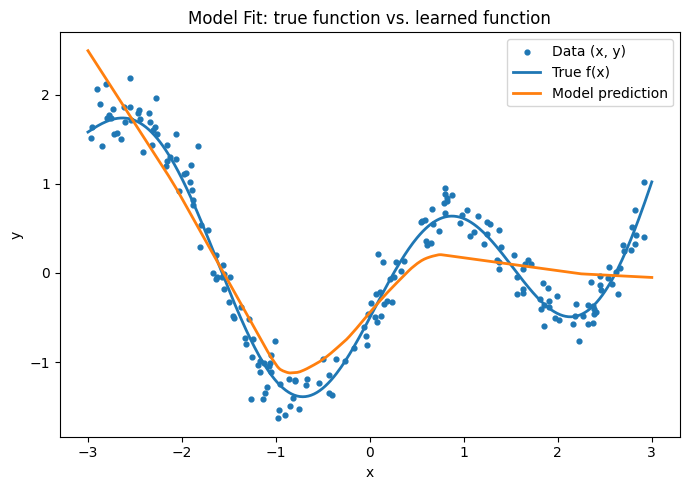

In [5]:
fig2 = plt.figure(figsize=(7, 5))
plt.scatter(x, y, s=12, label="Data (x, y)")
plt.plot(x_grid, y_true_grid, linewidth=2, label="True f(x)")
plt.plot(x_grid, y_pred_grid, linewidth=2, label="Model prediction")
plt.title("Model Fit: true function vs. learned function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()

TASK 6: Plot loss vs. number of epochs (epochs = 100)

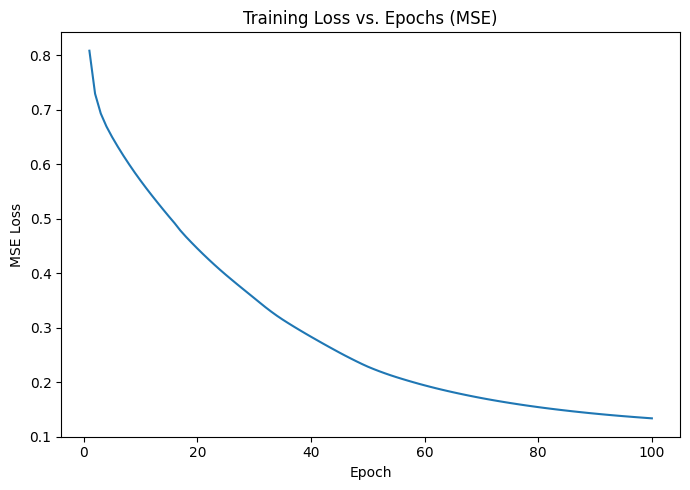

In [6]:
fig3 = plt.figure(figsize=(7, 5))
plt.plot(range(1, len(history_loss) + 1), history_loss)
plt.title("Training Loss vs. Epochs (MSE)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.tight_layout()

Analysis of Results
1. Model Fit (First Plot)

Observation:

* The blue curve (true function) captures the nonlinear sinusoidal + quadratic trend.

* The orange curve (model prediction) approximates the overall shape but misses some of the sharper oscillations.

* Around the regions near x ≈ -2 and x ≈ 2, the model underfits and produces smoother transitions than the true function.

Interpretation:

This indicates the model has learned the general trend but lacks enough flexibility to perfectly capture high-frequency variations.

Possible reasons:

* Limited capacity of the chosen architecture (two hidden layers may need more neurons).

* Learning rate with SGD may converge slower compared to optimizers like Adam.

* Noise in data makes exact fitting undesirable; the smoother curve shows the network is generalizing instead of memorizing noise.

2. Training Loss Curve (Second Plot)

Observation:

* Loss decreases steadily from ~0.8 → ~0.13 over 100 epochs.

* The curve shows a smooth decline without divergence or oscillation.

* Training has not plateaued fully, so with more epochs, loss might reduce further.

Interpretation:

* Indicates stable training with the chosen learning rate and optimizer.

* No signs of overfitting (loss is still decreasing).

* Model is learning meaningful features from the data.

✅ Final Discussion

* The model successfully learns the nonlinear mapping but shows signs of slight underfitting (not capturing small oscillations).

* Training is effective and converging, as shown by the steadily decreasing loss.

* For better results:

1.  Increase hidden layer size (e.g., 128 or 256 neurons).

2. Try Adam optimizer instead of plain SGD for faster convergence.

3. Train for more than 100 epochs.

4. Add dropout or L2 regularization if overfitting occurs in extended training.